# Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2023-10-13 06:19:28.041157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Let's create the `images/rnn` folder (if it doesn't exist) and define the `save_fig` function which is used through this notebook to save the figures in high-res for the book

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=100):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Basic RNN

In [5]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'./datasets/ridership.tgz'

In [6]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)   # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07

In [7]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


Let's look at the first few months of 2019

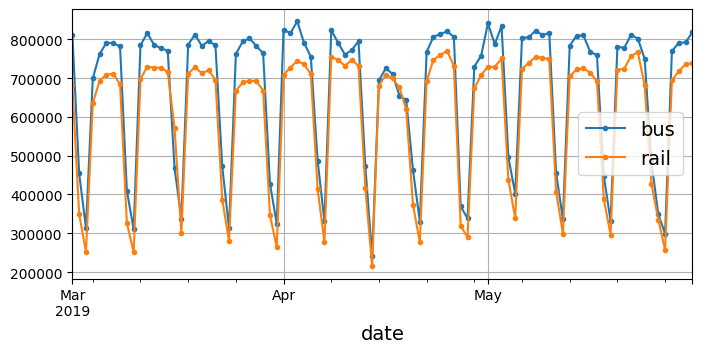

In [8]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

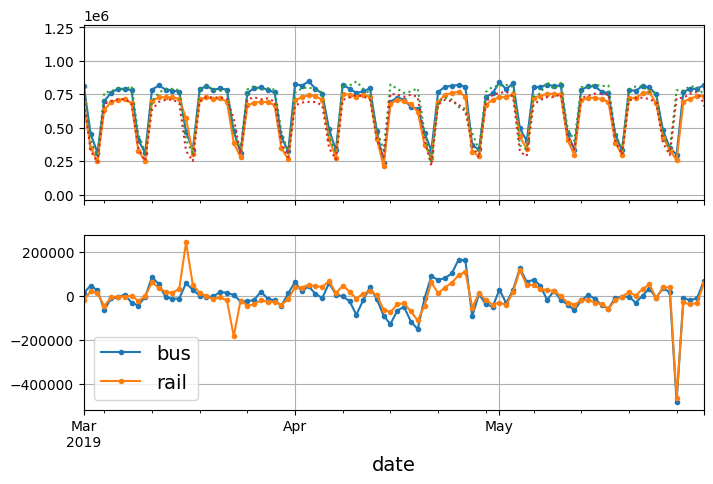

In [9]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
plt.show()

In [10]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [11]:
diff_7.head()

,bus,rail
date,,
2019-03-01,13927.0,-20019.0
2019-03-02,47280.0,21213.0
2019-03-03,25171.0,11672.0
2019-03-04,-63771.0,-45491.0
2019-03-05,-11268.0,-6517.0


In [12]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [13]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [14]:
targets

,bus,rail
date,,
2019-03-01,812238,682969
2019-03-02,454119,349392
2019-03-03,313539,252150
2019-03-04,699086,635353
2019-03-05,761781,692945
...,...,...
2019-05-27,298987,256757
2019-05-28,769069,694292
2019-05-29,791059,717681


Let's check whether there's any yearly seasonality

/var/folders/wr/cy7q4r6d4jz9c6t208k_b19r0000gn/T/ipykernel_71797/417956468.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample("M").mean()  # compute the mean for each month


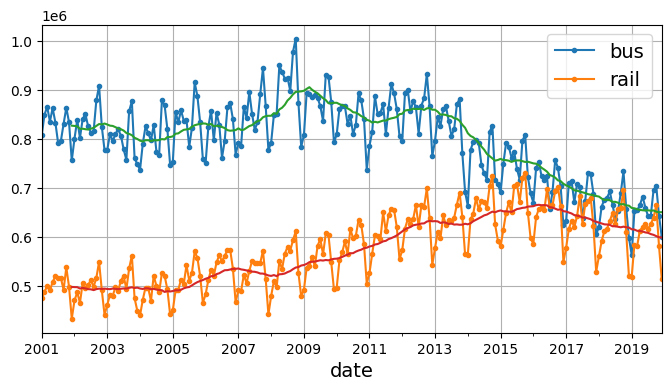

In [15]:
period = slice("2001", "2019")
df_monthly = df.resample("M").mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

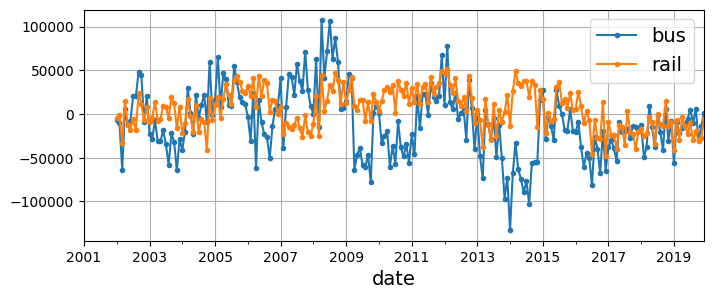

In [16]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show(3)

### The ARMA Model Family

In [17]:
from statsmodels.tsa.arima.model import ARIMA

In [18]:
origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [19]:
y_pred  # Seasonal ARIMA forecast

2019-06-01    427758.626313
Freq: D, dtype: float64

In [20]:
df["rail"].loc["2019-06-01"]  # Real value

379044

In [21]:
df["rail"].loc["2019-05-25"]  # Naive forecast

426932

In [22]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],   # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)
    
y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.72008847262

In [23]:
rail_series

date
2019-01-01    245852
2019-01-02    573542
2019-01-03    627781
2019-01-04    628514
2019-01-05    348257
               ...  
2019-05-27    256757
2019-05-28    694292
2019-05-29    717681
2019-05-30    735508
2019-05-31    738322
Freq: D, Name: rail, Length: 151, dtype: int64

In [24]:
time_period.shift(-1)

DatetimeIndex(['2019-02-28', '2019-03-01', '2019-03-02', '2019-03-03',
               '2019-03-04', '2019-03-05', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-09', '2019-03-10', '2019-03-11',
               '2019-03-12', '2019-03-13', '2019-03-14', '2019-03-15',
               '2019-03-16', '2019-03-17', '2019-03-18', '2019-03-19',
               '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-23',
               '2019-03-24', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31',
               '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
               '2019-04-05', '2019-04-06', '2019-04-07', '2019-04-08',
               '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12',
               '2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16',
               '2019-04-17', '2019-04-18', '2019-04-19', '2019-04-20',
               '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24',
      

### Preparing the Data for Machine Learning Models

In [25]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)

2023-10-13 06:19:46.739230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [27]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2023-10-13 06:19:46.988013: W tensorflow/core/framework/dataset.cc:769] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [28]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True):
    print(window_dataset)
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
0 1 2 3 
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
1 2 3 4 
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
2 3 4 5 


In [29]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_dataset in dataset:
    print(window_dataset)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([1 2 3 4], shape=(4,), dtype=int64)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int64)


In [30]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [31]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [32]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06"] / 1e6

In [33]:
rail_train

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
                ...   
2018-12-27    0.453029
2018-12-28    0.493961
2018-12-29    0.307105
2018-12-30    0.265310
2018-12-31    0.386058
Name: rail, Length: 1096, dtype: float64

In [34]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [35]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(8, 5))
    
    df = pd.DataFrame(history.history)
    df[["loss", "val_loss"]].plot(ax=axs[0])
    df[["mae", "val_mae"]].plot(ax=axs[1])
    
    plt.show()

### Forecasting Using a Linear Model

Epoch 1/500
33/33 [==============================] - 1s 10ms/step - loss: 0.0287 - mae: 0.1907 - val_loss: 0.0064 - val_mae: 0.0854
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0085 - mae: 0.0960 - val_loss: 0.0054 - val_mae: 0.0754
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0078 - mae: 0.0887 - val_loss: 0.0047 - val_mae: 0.0694
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0065 - mae: 0.0808 - val_loss: 0.0058 - val_mae: 0.0816
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0061 - mae: 0.0794 - val_loss: 0.0039 - val_mae: 0.0584
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0052 - mae: 0.0713 - val_loss: 0.0038 - val_mae: 0.0574
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0049 - mae: 0.0685 - val_loss: 0.0036 - val_mae: 0.0561
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0051 - 

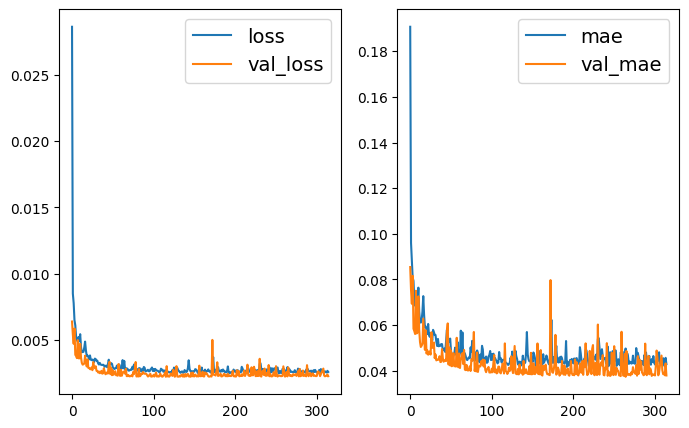

In [36]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

plot_history(history)

Epoch 1/500
33/33 [==============================] - 1s 6ms/step - loss: 0.0233 - mae: 0.1670 - val_loss: 0.0086 - val_mae: 0.1060
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0100 - mae: 0.1012 - val_loss: 0.0067 - val_mae: 0.0900
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0093 - mae: 0.0985 - val_loss: 0.0081 - val_mae: 0.1043
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0075 - mae: 0.0856 - val_loss: 0.0061 - val_mae: 0.0811
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0072 - mae: 0.0829 - val_loss: 0.0053 - val_mae: 0.0746
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0068 - mae: 0.0813 - val_loss: 0.0066 - val_mae: 0.0918
Epoch 7/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0068 - mae: 0.0813 - val_loss: 0.0048 - val_mae: 0.0711
Epoch 8/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0065 - m

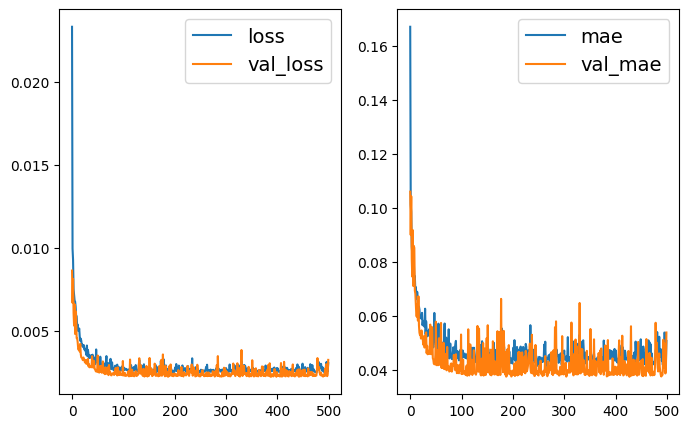

In [37]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=500,
    # callbacks=[early_stopping_cb]
)

plot_history(history)

Epoch 1/500
33/33 [==============================] - 1s 7ms/step - loss: 0.0458 - mae: 0.2669 - val_loss: 0.0278 - val_mae: 0.1974
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0201 - mae: 0.1639 - val_loss: 0.0112 - val_mae: 0.1194
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0121 - mae: 0.1200 - val_loss: 0.0074 - val_mae: 0.0950
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0096 - mae: 0.1022 - val_loss: 0.0065 - val_mae: 0.0911
Epoch 5/500
33/33 [==============================] - 0s 3ms/step - loss: 0.0089 - mae: 0.0989 - val_loss: 0.0064 - val_mae: 0.0935
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0084 - mae: 0.0954 - val_loss: 0.0055 - val_mae: 0.0868
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0079 - mae: 0.0921 - val_loss: 0.0057 - val_mae: 0.0869
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0076 - m

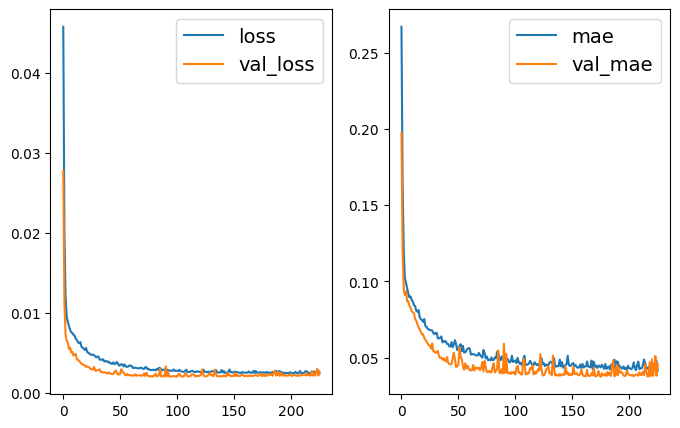

In [38]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae",
    patience=50,
    restore_best_weights=True
)

opt = tf.keras.optimizers.Adam(learning_rate=0.002)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=opt,
    metrics=["mae"]
)
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=500,
    callbacks=[early_stopping_cb]
)

plot_history(history)

### Forecasting Using a Simple RNN

In [39]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True
    )
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=opt,
        metrics=["mae"]
    )
    history = model.fit(
        train_set,
        validation_data=valid_set,
        epochs=epochs,
        callbacks=[early_stopping_cb]
    )
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [40]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [41]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0706 - mae: 0.2727 - val_loss: 0.0254 - val_mae: 0.1390
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0201 - mae: 0.1682 - val_loss: 0.0189 - val_mae: 0.1447
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0191 - mae: 0.1631 - val_loss: 0.0184 - val_mae: 0.1422
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0184 - mae: 0.1624 - val_loss: 0.0176 - val_mae: 0.1435
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0179 - mae: 0.1621 - val_loss: 0.0173 - val_mae: 0.1411
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0175 - mae: 0.1609 - val_loss: 0.0169 - val_mae: 0.1403
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0170 - mae: 0.1623 - val_loss: 0.0165 - val_mae: 0.1396
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0166 - 

120826.71374082565

In [42]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [43]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0278 - mae: 0.1825 - val_loss: 0.0160 - val_mae: 0.1547
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0089 - mae: 0.1060 - val_loss: 0.0057 - val_mae: 0.0920
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0068 - mae: 0.0905 - val_loss: 0.0054 - val_mae: 0.0901
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0060 - mae: 0.0832 - val_loss: 0.0036 - val_mae: 0.0694
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0048 - mae: 0.0711 - val_loss: 0.0031 - val_mae: 0.0625
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0043 - mae: 0.0642 - val_loss: 0.0024 - val_mae: 0.0492
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0037 - mae: 0.0572 - val_loss: 0.0023 - val_mae: 0.0428
Epoch 8/500
33/33 [==============================] - 0s 10ms/step - loss: 0.003

29520.15958726406

In [44]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(56, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.002)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0845 - mae: 0.3090 - val_loss: 0.0207 - val_mae: 0.1613
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0120 - mae: 0.1271 - val_loss: 0.0099 - val_mae: 0.1109
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0099 - mae: 0.1152 - val_loss: 0.0089 - val_mae: 0.1006
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0084 - mae: 0.1031 - val_loss: 0.0066 - val_mae: 0.0875
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0070 - mae: 0.0914 - val_loss: 0.0054 - val_mae: 0.0787
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0057 - mae: 0.0793 - val_loss: 0.0044 - val_mae: 0.0697
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0050 - mae: 0.0716 - val_loss: 0.0037 - val_mae: 0.0632
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0045 - 

29175.11574923992

In [45]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.002)

Epoch 1/500
33/33 [==============================] - 3s 37ms/step - loss: 0.0575 - mae: 0.2603 - val_loss: 0.0126 - val_mae: 0.1279
Epoch 2/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0141 - mae: 0.1389 - val_loss: 0.0109 - val_mae: 0.1061
Epoch 3/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0118 - mae: 0.1269 - val_loss: 0.0090 - val_mae: 0.0952
Epoch 4/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0100 - mae: 0.1131 - val_loss: 0.0064 - val_mae: 0.0851
Epoch 5/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0084 - mae: 0.1000 - val_loss: 0.0064 - val_mae: 0.0822
Epoch 6/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0072 - mae: 0.0896 - val_loss: 0.0036 - val_mae: 0.0646
Epoch 7/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0062 - mae: 0.0804 - val_loss: 0.0039 - val_mae: 0.0642
Epoch 8/500
33/33 [==============================] - 1s 24ms/step - loss: 0.

27950.981631875038

In [46]:
deep_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          1088      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


### Forecasting Multivariate Time Series

In [47]:
df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)

In [48]:
df_mulvar

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
...,...,...,...,...,...
2021-11-26,0.257700,0.189694,1,0,0
2021-11-27,0.237839,0.187065,0,1,0
2021-11-28,0.184817,0.147830,0,0,1


In [49]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


In [50]:
df.shift(-1)

,day_type,bus,rail
date,,,
2001-01-01,W,780827.0,501952.0
2001-01-02,W,824923.0,536432.0
2001-01-03,W,870021.0,550011.0
2001-01-04,W,890426.0,557917.0
2001-01-05,A,577401.0,255356.0
...,...,...,...
2021-11-26,A,237839.0,187065.0
2021-11-27,U,184817.0,147830.0
2021-11-28,W,421322.0,276090.0


In [51]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [52]:
mulvar_train

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,1,0,0
2016-01-02,0.448859,0.365509,0,1,0
2016-01-03,0.340540,0.287661,0,0,1
2016-01-04,0.829429,0.703185,0,0,1
2016-01-05,0.846789,0.727716,0,0,1
...,...,...,...,...,...
2018-12-27,0.509948,0.453029,0,0,1
2018-12-28,0.577497,0.493961,1,0,0
2018-12-29,0.394088,0.307105,0,1,0


In [53]:
mulvar_valid

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2019-01-01,0.248879,0.245852,0,0,1
2019-01-02,0.591006,0.573542,0,0,1
2019-01-03,0.664442,0.627781,0,0,1
2019-01-04,0.668812,0.628514,1,0,0
2019-01-05,0.444434,0.348257,0,1,0
...,...,...,...,...,...
2019-05-27,0.298987,0.256757,0,0,1
2019-05-28,0.769069,0.694292,0,0,1
2019-05-29,0.791059,0.717681,0,0,1


In [54]:
mulvar_test

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2019-06-01,0.473204,0.379044,0,1,0
2019-06-02,0.370049,0.319334,0,0,1
2019-06-03,0.814607,0.731571,0,0,1
2019-06-04,0.797511,0.749759,0,0,1
2019-06-05,0.817943,0.764911,0,0,1
...,...,...,...,...,...
2021-11-26,0.257700,0.189694,1,0,0
2021-11-27,0.237839,0.187065,0,1,0
2021-11-28,0.184817,0.147830,0,0,1


In [55]:
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # shuffle=True,
    # seed=42
)
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.002)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0872 - mae: 0.3247 - val_loss: 0.0076 - val_mae: 0.0893
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0073 - mae: 0.0877 - val_loss: 0.0032 - val_mae: 0.0660
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0039 - mae: 0.0612 - val_loss: 0.0022 - val_mae: 0.0505
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0034 - mae: 0.0558 - val_loss: 0.0020 - val_mae: 0.0472
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0032 - mae: 0.0527 - val_loss: 0.0017 - val_mae: 0.0423
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0031 - mae: 0.0516 - val_loss: 0.0018 - val_mae: 0.0451
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0030 - mae: 0.0507 - val_loss: 0.0017 - val_mae: 0.0445
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0029 -

26359.274983406067

In [56]:
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = mulvar_train["bus"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["bus"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # shuffle=True,
    # seed=42
)
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.002)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0912 - mae: 0.3215 - val_loss: 0.0110 - val_mae: 0.1247
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0093 - mae: 0.1049 - val_loss: 0.0035 - val_mae: 0.0672
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0056 - mae: 0.0740 - val_loss: 0.0023 - val_mae: 0.0507
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0048 - mae: 0.0682 - val_loss: 0.0022 - val_mae: 0.0495
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0666 - val_loss: 0.0022 - val_mae: 0.0499
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0045 - mae: 0.0652 - val_loss: 0.0023 - val_mae: 0.0520
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0043 - mae: 0.0642 - val_loss: 0.0020 - val_mae: 0.0482
Epoch 8/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0

25485.023856163025

In [57]:
tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets = mulvar_train[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    # shuffle=True,
    # seed=42
)
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds, learning_rate=0.002)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.1070 - mae: 0.3385 - val_loss: 0.0236 - val_mae: 0.1715
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0163 - mae: 0.1350 - val_loss: 0.0077 - val_mae: 0.0927
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0073 - mae: 0.0892 - val_loss: 0.0040 - val_mae: 0.0659
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0053 - mae: 0.0752 - val_loss: 0.0030 - val_mae: 0.0563
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0044 - mae: 0.0667 - val_loss: 0.0023 - val_mae: 0.0490
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0039 - mae: 0.0625 - val_loss: 0.0021 - val_mae: 0.0462
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0036 - mae: 0.0591 - val_loss: 0.0019 - val_mae: 0.0435
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0034 - 

26236.00699007511

### Forecasting Several Time Steps Ahead

In [58]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)
    
y_pred_one

1/1 [==============================] - 0s 25ms/step


array([[0.636594]], dtype=float32)

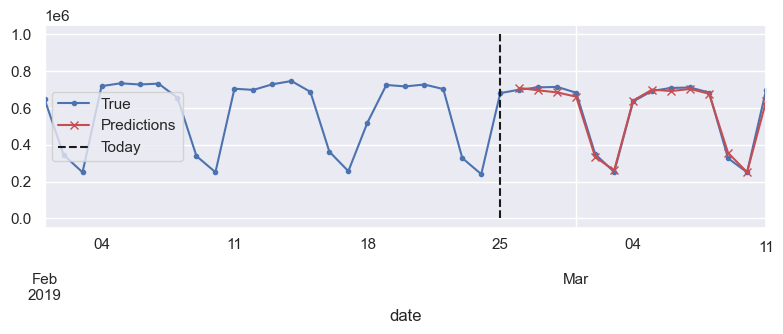

In [59]:
import seaborn as sns
sns.set()


Y_pred = pd.Series(
    X[0, -14:, 0],
    index=pd.date_range("2019-02-26", "2019-03-11")
)

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax
)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax
)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

In [60]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)


ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(
    ahead_model,
    ahead_train_ds,
    ahead_valid_ds,
    learning_rate=0.02
)

Epoch 1/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0760 - mae: 0.2948 - val_loss: 0.0231 - val_mae: 0.1622
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0201 - mae: 0.1646 - val_loss: 0.0172 - val_mae: 0.1384
Epoch 3/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0163 - mae: 0.1495 - val_loss: 0.0144 - val_mae: 0.1328
Epoch 4/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0147 - mae: 0.1424 - val_loss: 0.0131 - val_mae: 0.1257
Epoch 5/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0135 - mae: 0.1364 - val_loss: 0.0123 - val_mae: 0.1198
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0126 - mae: 0.1299 - val_loss: 0.0111 - val_mae: 0.1159
Epoch 7/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0118 - mae: 0.1250 - val_loss: 0.0103 - val_mae: 0.1109
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0112 - 

KeyboardInterrupt: 

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
print(X.shape)


In [ ]:
Y_pred = ahead_model.predict(X)
print(Y_pred.shape)
print(Y_pred)

### Forecasting Using a Sequence-to-Sequence Model

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

In [ ]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

In [ ]:
ds = to_windows(my_series, 3)
list(ds)

In [ ]:
list(ds.map(lambda s: (s[0], s[1:])))  

In [ ]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [ ]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [ ]:
tf.random.set_seed(42)

seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14),
])

fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid, learning_rate=0.1)

In [ ]:
r = tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, seq_length, 8])
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
print(X.shape)
r(X)

In [ ]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
print(X.shape)
y_pred_14 = seq2seq_model.predict(X)
print(y_pred_14.shape)
print(y_pred_14[0])

In [ ]:
d = tf.keras.utils.timeseries_dataset_from_array(mulvar_valid["rail"], sequence_length=14, targets=None)
values = list(d)[0].numpy()

In [ ]:
y_pred_14[0].shape

In [ ]:
values[1:56].shape

In [ ]:
# mean(abs(y_pred_14[0] - values[1:57]))
mae = tf.keras.losses.MeanAbsoluteError()
mae(y_pred_14[0], values[1:57]) * 1e6

In [ ]:
mulvar_valid.rail

## Deep RNNs with Layer Norm

In [ ]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
        
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=5)

## LSTM

In [ ]:
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid, learning_rate=0.1, epochs=1000)